In [1]:
import sys

sys.path.append("../")

In [2]:
from datetime import datetime

import numpy as np
from gym.wrappers import TimeLimit

from src.environments import ea
from src.wrappers import PlotEpisode, RecordEpisode

A simple example where we use random settings on the magnets (`env.action_space.sample()`).

There are a few things on the which we don't know on the real accelerator. For now let's start setting them to simple values. We can make them more difficult later.

- `incoming_mode`: What does the beam look like upstream of the section we are considering?
- `misalignment_mode`: The quadrupole magnets and the screen can be misaligned, and that effects their behaviour. For now, we consider them perfectly aligned.
- `target_beam_mode`: What do we want the beam to look like on the screen?
- `magnet_init_mode`: When the controller takes over, what are the magnets set to?

Note that we also have so-called Wrappers from Gymnasium. They allow us to slightly modify how the environment works without having to modify the environment itself. Here, `TimeLimit` determines the maximum number of steps the environment runs for. `RecordEpisode` is a convenient wrapper that automatically records what happens while the controller runs. `PlotEpisode` automatically plots what happened while your controller ran.


Overwriting existing episode plots at /Users/jankaiser/Documents/DESY/ares-classical-control/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.


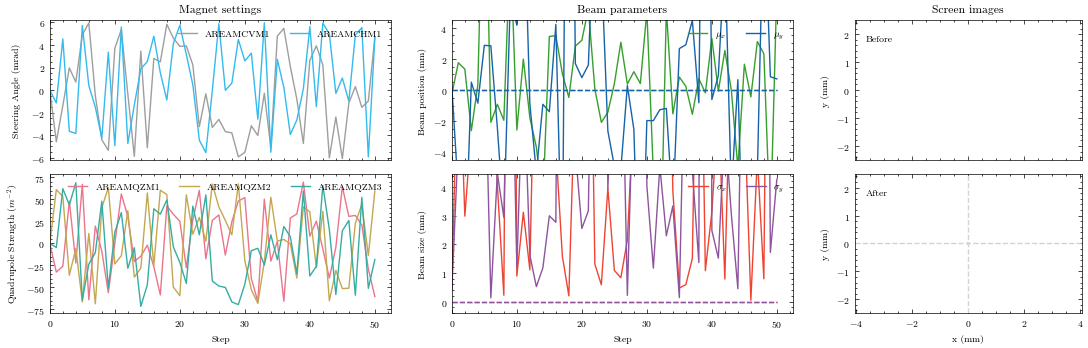

In [3]:
env = ea.TransverseTuning(
    backend="cheetah",
    backend_args={
        "generate_screen_images": True,
        "incoming_mode": "random",
        "misalignment_mode": np.zeros(8),
    },
    action_mode="direct",
    target_beam_mode=np.zeros(4),
    magnet_init_mode=np.zeros(5),
)
env = TimeLimit(env, max_episode_steps=50)
env = RecordEpisode(
    env, save_dir=f"../data/classical_control/example_{datetime.now():%Y%m%d%H%M}"
)
env = PlotEpisode(env, save_dir="../plots")

observation, info = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()

We can instantiate the environment again and have a look what the observations look like. You will probably only care about the `"beam"` and `"target"` keys.


In [4]:
env = ea.TransverseTuning(
    backend="cheetah",
    backend_args={
        "generate_screen_images": True,
        "incoming_mode": "random",
        "misalignment_mode": np.zeros(8),
    },
    action_mode="direct",
    target_beam_mode=np.zeros(4),
    magnet_init_mode=np.zeros(5),
)
env = TimeLimit(env, max_episode_steps=50)
env = RecordEpisode(
    env, save_dir=f"../data/classical_control/example_{datetime.now():%Y%m%d%H%M}"
)
env = PlotEpisode(env, save_dir="../plots")

Overwriting existing data recordings at /Users/jankaiser/Documents/DESY/ares-classical-control/data/classical_control/example_202401081534 folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
Overwriting existing episode plots at /Users/jankaiser/Documents/DESY/ares-classical-control/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.


In [5]:
observation, info = env.reset()
observation

{'beam': array([ 0.00030593,  0.00022077, -0.0006353 ,  0.00034927], dtype=float32),
 'magnets': array([0., 0., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., 0.], dtype=float32)}

In [6]:
observation, reward, terminated, truncated, info = env.step(
    np.array([0.0, 0.0, 0.0, 0.0, 0.0])
)
observation

{'beam': array([ 0.00030593,  0.00022077, -0.0006353 ,  0.00034927], dtype=float32),
 'magnets': array([0., 0., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., 0.], dtype=float32)}

In [7]:
from gymnasium.wrappers import FlattenObservation, FrameStack, RescaleAction
from stable_baselines3 import PPO

from src.utils import load_config
from src.wrappers import RescaleObservation

model_name = "vital-breeze-514"
config = load_config(f"../models/ea/ppo/{model_name}/config")
model = PPO.load(f"../models/ea/ppo/{model_name}/model")

Overwriting existing episode plots at /Users/jankaiser/Documents/DESY/ares-classical-control/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.


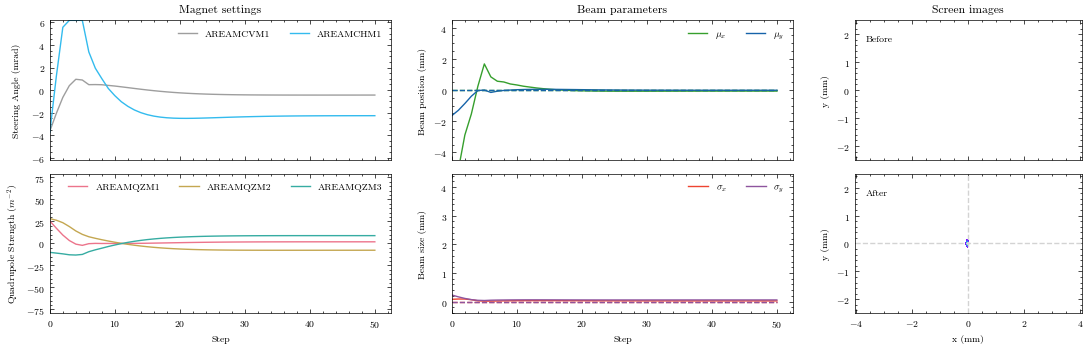

In [8]:
env = ea.TransverseTuning(
    backend="cheetah",
    backend_args={"generate_screen_images": True},
    action_mode=config["action_mode"],
    magnet_init_mode=config["magnet_init_mode"],
    max_quad_setting=config["max_quad_setting"],
    max_quad_delta=config["max_quad_delta"],
    max_steerer_delta=config["max_steerer_delta"],
    target_beam_mode=np.zeros(4),
)
env = TimeLimit(env, 50)
# env = RecordEpisode(env)
env = PlotEpisode(env, save_dir="../plots")
if config["normalize_observation"] and not config["running_obs_norm"]:
    env = RescaleObservation(env, -1, 1)
if config["rescale_action"]:
    env = RescaleAction(env, -1, 1)
env = FlattenObservation(env)
if config["frame_stack"] > 1:
    env = FrameStack(env, config["frame_stack"])

observation, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
env.close()